## Pair Generation

Generating pairs.    
Prefs[0] = x1 descriptors     
Prefs[1] = x2 descriptors    
Prefs[2] = y1  
Prefs[3] = y2 

In [1]:
import numpy as np
import pandas as pd
import pickle

from DPDI.utilities.pairs_generator import PairsGenerator
from DPDI.IntegNet import IntegNet

from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('Data/chembl_fax_rdkit1d_normalized.csv')
df.head()

,smiles,value,assay,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,MaxPartialCharge,MinPartialCharge,...,fr_piperzine,fr_priamide,fr_pyridine,fr_sulfide,fr_sulfone,fr_term_acetylene,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,N=C(N)c1cccc(CN2CC[C@H](NS(=O)(=O)c3ccc(-c4ccn...,0.477024,CHEMBL3885768,0.240192,0.257329,0.115358,0.343176,0.231894,0.028575,0.785021,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,N=C(N)c1cccc(CN2CC[C@H](NS(=O)(=O)c3ccc(-c4ccn...,0.490153,CHEMBL3885772,0.240192,0.257329,0.115358,0.343176,0.231894,0.028575,0.785021,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,N=C(N)c1cccc(CN2CC[C@H](NS(=O)(=O)c3ccc(-c4ccn...,0.446389,CHEMBL3885774,0.240192,0.257329,0.115358,0.343176,0.231894,0.028575,0.785021,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,N=C(N)c1cccc(CN2CC[C@H](NS(=O)(=O)c3ccc(-c4ccn...,0.452954,CHEMBL3885775,0.240192,0.257329,0.115358,0.343176,0.231894,0.028575,0.785021,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,O=C1[C@@H](NS(=O)(=O)c2cc3ncccc3s2)CCN1Cc1cc2c...,0.527352,CHEMBL3885768,0.220448,0.262623,0.488022,0.524445,0.145951,0.028822,0.878645,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [3]:
#Check assay ID and the number of molecules in each group.
for assay in df['assay'].unique():
    print (assay,len(df[df['assay']==assay]))

CHEMBL3885768 55
CHEMBL3885772 55
CHEMBL3885774 55
CHEMBL3885775 56
CHEMBL968695 55
CHEMBL659609 62
CHEMBL885070 46
CHEMBL3887092 85


In [4]:
#Involve all molecules as training group for pairs generation. Assay with only 1 molecule will be dropped.
PG = PairsGenerator(df)
prefs = PG.generate()

The number of identical assay group is: 8
The length of total prefs is: 13821


## Model Training

Train set: training the model.    
Val set: tune hyperparameters.     
Test set: verify performances.   
The ndcg ranking score requires a true ranking of the input list. To calculate the ndcg, we need keep the predicted molecules in same assay group.     
In actual use, input all data as training set for predicting unknown molecules after tuning hyperparameters.

In [5]:
train_set,val_set = train_test_split(df[df['assay'] != 'CHEMBL3887092'])
test_set = df[df['assay'] == 'CHEMBL3887092']

In [6]:
PG = PairsGenerator(train_set)
train_prefs = PG.generate()
PG = PairsGenerator(val_set)
val_prefs = PG.generate()
#PG.x,PG.y are descriptors and pchembl value of val_set dataframe in a numpy array form.

The number of identical assay group is: 7
The length of total prefs is: 5723
The number of identical assay group is: 7
The length of total prefs is: 671


In [7]:
#load settings
#example is 2-hidden-layer neural network with SGD optimizer(Adam available)
#number of input equals descriptors length, set number of neurons in layer 1 and 2 
#cuda default is None for cpu training
model = IntegNet(129,512,128,optim='SGD',batch_size= 256,n_epoch=200,learning_rate=0.005,cuda='cuda:0')
model.load_train_pair(train_prefs)
model.load_val_pair(val_prefs,PG.x,PG.y)

100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [04:45<00:00,  1.43s/it]

Final Train loss is: 0.32201493434284045 val loss is: 0.5498783588409424
Final Train NDCG is: 0.9772216968119989 Final val NDCG is: 0.90027395683222


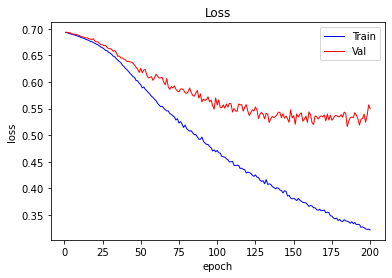

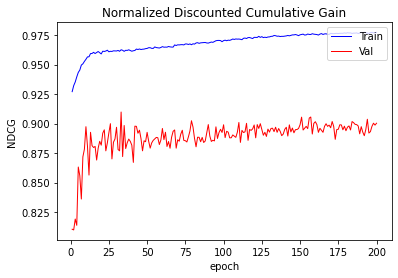

In [8]:
# 1 epoch is defined as training all pairs instead of all molecules.
# defining number of epoch and learning rate has higher priority
# set n_epochs_stop for early stop
# add n_epochs for better model
model.train_pair(ep=200,lr=0.01,n_epochs_stop=30,printres=True,plotres=True,printloss=False)

## Save and load DPDI Model

In [9]:
modelname = 'model/finalized_model.pkl'
pickle.dump(model, open(modelname, 'wb'))

In [10]:
loaded_model = pickle.load(open(modelname, 'rb'))

## Predicting new molecules

In [14]:
# if the test set has not been normalized before, use before saved Minmax value of each column to scale it. 
# from DPDI.utilities.feature_engineering import reverse
# test_set = reverse(test_set)
test_set.head()

,smiles,value,assay,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,MaxPartialCharge,MinPartialCharge,...,fr_piperzine,fr_priamide,fr_pyridine,fr_sulfide,fr_sulfone,fr_term_acetylene,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
153,CCOc1cc2c(N)nccc2cc1C[C@H](C(=O)O)N1CC[C@H](NS...,0.343545,CHEMBL3887092,0.454429,0.177146,0.023760,0.260544,0.707041,0.257546,0.417948,...,0.0,0.0,0.5,0.0,0.0,0.0,1.0,0.0,0.0,0.0
154,COC(=O)[C@@H](Cc1cc2ccnc(N)c2cc1OC(F)(F)F)N1CC...,0.013129,CHEMBL3887092,0.459838,0.005852,0.012673,0.192049,0.872378,1.000000,0.505134,...,0.0,0.0,0.5,0.0,0.0,0.0,1.0,0.0,0.0,0.0
155,COC(=O)[C@@H](Cc1cc2ccnc(N)c2cc1F)N1CC[C@H](NS...,0.059081,CHEMBL3887092,0.852523,0.188579,0.151821,0.368090,0.567230,0.264054,0.505134,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156,COc1cc2c(N)nccc2cc1C[C@H](C(=O)O)N1CC[C@H](NS(...,0.776805,CHEMBL3887092,0.333091,0.211611,0.127987,0.330934,0.455608,0.257546,0.408333,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
157,CCOC(=O)[C@@H](Cc1cc2ccnc(N)c2cc1OC)N1CC[C@H](...,0.407002,CHEMBL3887092,0.408238,0.215740,0.173094,0.313816,0.541552,0.264855,0.408333,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
#The prediction is surrogate value only for ranking. Negative number is acceptable. 
x = np.array(test_set.drop(['smiles','value','assay'],axis=1))
pred_y = loaded_model.predict(x)
print(pred_y)
res = pd.concat([test_set['smiles'],pd.DataFrame({'pred_value':pred_y}).set_index(test_set.index)],axis=1)
res

[-1.4002954   0.09351856 -0.3855068  -2.9241128  -1.0871704   0.91476023
 -1.1158445  -2.0251615   1.4911327  -1.8385124  -2.9240832  -1.4707011
 -1.4001238  -1.8525149  -0.12492952 -1.304274   -2.2296748  -0.7600633
 -0.65520084 -0.383196   -2.7950428  -1.6985021  -1.7217685   0.35735464
 -1.190069   -1.3090426  -1.9579406  -1.4211136  -1.9111372  -1.8631464
 -2.3930776  -1.1035527  -1.2442901   0.21513852 -0.32485282 -0.7851641
 -1.0291455  -2.3035717  -1.11591    -0.83119416 -2.076385   -1.5394866
 -1.9641085  -1.3872988   0.16114798 -0.4654739  -0.19083081 -2.3568783
 -2.0704052  -0.9819641  -1.9025068  -2.015341   -2.6128254   0.43415385
 -0.7378543  -1.7306882  -1.8069602  -0.37471712 -1.8092103  -2.2462115
 -2.271363    0.3936357  -2.3821874  -2.2479188  -0.26088667 -2.4680681
 -0.3208356  -2.6856937  -1.0633312  -0.57688296 -0.31276    -0.8492989
 -2.4294758  -0.8957543  -1.0501616  -1.7523451  -0.07823297 -1.832142
 -2.971512   -0.70899326 -2.3290794  -0.06025294 -0.915375   -

,smiles,pred_value
153,CCOc1cc2c(N)nccc2cc1C[C@H](C(=O)O)N1CC[C@H](NS...,-1.400295
154,COC(=O)[C@@H](Cc1cc2ccnc(N)c2cc1OC(F)(F)F)N1CC...,0.093519
155,COC(=O)[C@@H](Cc1cc2ccnc(N)c2cc1F)N1CC[C@H](NS...,-0.385507
156,COc1cc2c(N)nccc2cc1C[C@H](C(=O)O)N1CC[C@H](NS(...,-2.924113
157,CCOC(=O)[C@@H](Cc1cc2ccnc(N)c2cc1OC)N1CC[C@H](...,-1.087170
...,...,...
310,CN(C)c1ncc(S(=O)(=O)N[C@H]2CCN([C@H](Cc3cc4ccn...,-2.329079
311,CCOC(=O)[C@@H](Cc1cc2ccnc(N)c2cc1OC)N1CC[C@H](...,-0.060253
312,COC(=O)[C@@H](Cc1cc2ccnc(N)c2cc1OC(F)(F)F)N1CC...,-0.915375
313,CN(C)c1ccc(S(=O)(=O)N[C@H]2CCN([C@H](Cc3cc4ccn...,-2.026787
